In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from post_processing import *
from utils_mini import *
import lightgbm as lgb

from scipy import signal
# from scipy.fft import fftshift

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [2]:
# chris clean dataset
df_train = pd.read_csv("../input/train_clean.csv")
df_test = pd.read_csv("../input/test_clean.csv")

df_train["local_time"] = df_train.time % 50
df_train.loc[df_train.local_time == 0.0000, "local_time"] = 50

df_test["local_time"] = df_test.time % 50
df_test.loc[df_test.local_time == 0.0000, "local_time"] = 50

df_test["mini_local_time"] = df_test.time % 10
df_test.loc[df_test.local_time == 0.0000, "mini_local_time"] = 10

BATCH_SIZE = 500000

# train
for batch_i in range(10):
    df_train.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 500000, 'batch'] = batch_i + 1

    df_train.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 100000, 'mini_batch'] = 1
    df_train.loc[BATCH_SIZE * batch_i + 100000:BATCH_SIZE * batch_i + 200000, 'mini_batch'] = 2
    df_train.loc[BATCH_SIZE * batch_i + 200000:BATCH_SIZE * batch_i + 300000, 'mini_batch'] = 3
    df_train.loc[BATCH_SIZE * batch_i + 300000:BATCH_SIZE * batch_i + 400000, 'mini_batch'] = 4
    df_train.loc[BATCH_SIZE * batch_i + 400000:BATCH_SIZE * batch_i + 500000, 'mini_batch'] = 5

df_train = df_train.drop(df_train[(df_train.batch.isin([8]))].index)
df_train.loc[(df_train.batch.isin([5,10])), "signal"] += 2.726

In [3]:
# df_train = pd.read_pickle('../features/train_v2.pkl')
TARGET = "open_channels"

print(df_train.shape)
df_train.head()

(4500000, 6)


,time,signal,open_channels,local_time,batch,mini_batch
0,0.0001,-2.7600,0,0.0001,1.0,1.0
1,0.0002,-2.8557,0,0.0002,1.0,1.0
2,0.0003,-2.4074,0,0.0003,1.0,1.0
3,0.0004,-3.1404,0,0.0004,1.0,1.0
4,0.0005,-3.1525,0,0.0005,1.0,1.0


In [4]:
import pywt
def denoise_signal_simple(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="constant")
    # univeral threshold
    uthresh = level
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard')
                 for i in coeff[1:])
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec(coeff, wavelet, mode='constant')

In [23]:
def fe(df):

    df["signal_pow_2"] = df["signal"] ** 2
    df["signal_grad"] = np.gradient(df["signal"])
    df['pct_change'] = df['signal'].pct_change()
    
    # shift features
    for shift_val in range(1, 5):

        df[f'shift+{shift_val}'] = df.groupby(['batch']).shift(shift_val)['signal'].fillna(0)
        df[f'shift_{shift_val}'] = df.groupby(['batch']).shift(-shift_val)['signal'].fillna(0)

    # sin and cos (overfit)
    for angle_shift in range(1, 2):
        df[f'sin_{angle_shift}'] = np.sin(df["signal"] * angle_shift)
        df[f'cos_{angle_shift}'] = np.cos(df["signal"] * angle_shift)
        
    # group features
    for r in [10, 30, 100, 300, 1000, 3000]:
        df[f'mean_{r}'] = df.groupby('batch')['signal'].rolling(
            r).mean().reset_index()['signal']
        df[f'std_{r}'] = df.groupby('batch')['signal'].rolling(
            r).std().reset_index()['signal']

    return df

print("feature engineering on training data ...")
df_train = fe(df_train)

# df_train.dropna(inplace=True)
df_train.head()

feature engineering on training data ...


,time,signal,open_channels,local_time,batch,mini_batch,signal_pow_2,signal_grad,pct_change,shift+1,shift_1,pct_change+1,pct_change_1,shift+2,shift_2,pct_change+2,pct_change_2,shift+3,shift_3,pct_change+3,pct_change_3,shift+4,shift_4,pct_change+4,pct_change_4,sin_1,cos_1,mean_10,std_10,mean_30,std_30,mean_100,std_100,mean_300,std_300,mean_1000,std_1000,mean_3000,std_3000,oof
2002999,200.3000,2.1765,4,0.3000,5.0,1.0,4.737152,1.27870,NaN,0.0000,3.4552,-0.239507,0.587503,0.0000,2.1060,-0.110027,-0.390484,0.0000,4.1403,0.569940,0.965954,0.0000,3.9688,-0.433596,-0.041422,0.822102,-0.569341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2003000,200.3001,3.4552,5,0.3001,5.0,1.0,11.938407,-0.03525,0.587503,2.1765,2.1060,0.056502,-0.390484,0.0000,4.1403,-0.239507,0.965954,0.0000,3.9688,-0.110027,-0.041422,0.0000,2.4890,0.569940,-0.372858,-0.308492,-0.951227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
2003001,200.3002,2.1060,4,0.3002,5.0,1.0,4.435236,0.34255,-0.390484,3.4552,4.1403,0.587503,0.965954,2.1765,3.9688,0.056502,-0.041422,0.0000,2.4890,-0.239507,-0.372858,0.0000,2.0333,-0.110027,-0.183086,0.860165,-0.510016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2003002,200.3003,4.1403,6,0.3003,5.0,1.0,17.142084,0.93140,0.965954,2.1060,3.9688,-0.390484,-0.041422,3.4552,2.4890,0.587503,-0.372858,2.1765,2.0333,0.056502,-0.183086,0.0000,2.5269,-0.239507,0.242758,-0.840772,-0.541390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
2003003,200.3004,3.9688,5,0.3004,5.0,1.0,15.751373,-0.82565,-0.041422,4.1403,2.4890,0.965954,-0.372858,2.1060,2.0333,-0.390484,-0.183086,3.4552,2.5269,0.587503,0.242758,2.1765,1.8128,0.056502,-0.282599,-0.736044,-0.676934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [26]:
df_train.fillna(0, inplace=True)
df_train

,time,signal,open_channels,local_time,batch,mini_batch,signal_pow_2,signal_grad,pct_change,shift+1,shift_1,pct_change+1,pct_change_1,shift+2,shift_2,pct_change+2,pct_change_2,shift+3,shift_3,pct_change+3,pct_change_3,shift+4,shift_4,pct_change+4,pct_change_4,sin_1,cos_1,mean_10,std_10,mean_30,std_30,mean_100,std_100,mean_300,std_300,mean_1000,std_1000,mean_3000,std_3000,oof
2002999,200.3000,2.1765,4,0.3000,5.0,1.0,4.737152,1.27870,0.000000,0.0000,3.4552,-0.239507,0.587503,0.0000,2.1060,-0.110027,-0.390484,0.0000,4.1403,0.569940,0.965954,0.0000,3.9688,-0.433596,-0.041422,0.822102,-0.569341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2003000,200.3001,3.4552,5,0.3001,5.0,1.0,11.938407,-0.03525,0.587503,2.1765,2.1060,0.056502,-0.390484,0.0000,4.1403,-0.239507,0.965954,0.0000,3.9688,-0.110027,-0.041422,0.0000,2.4890,0.569940,-0.372858,-0.308492,-0.951227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2003001,200.3002,2.1060,4,0.3002,5.0,1.0,4.435236,0.34255,-0.390484,3.4552,4.1403,0.587503,0.965954,2.1765,3.9688,0.056502,-0.041422,0.0000,2.4890,-0.239507,-0.372858,0.0000,2.0333,-0.110027,-0.183086,0.860165,-0.510016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2003002,200.3003,4.1403,6,0.3003,5.0,1.0,17.142084,0.93140,0.965954,2.1060,3.9688,-0.390484,-0.041422,3.4552,2.4890,0.587503,-0.372858,2.1765,2.0333,0.056502,-0.183086,0.0000,2.5269,-0.239507,0.242758,-0.840772,-0.541390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
2003003,200.3004,3.9688,5,0.3004,5.0,1.0,15.751373,-0.82565,-0.041422,4.1403,2.4890,0.965954,-0.372858,2.1060,2.0333,-0.390484,-0.183086,3.4552,2.5269,0.587503,0.242758,2.1765,1.8128,0.056502,-0.282599,-0.736044,-0.676934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499991,249.9992,4.9039,6,49.9992,5.0,5.0,24.048235,0.63925,0.600333,3.0643,4.3428,-0.266668,-0.114419,4.1786,5.1962,-0.135116,0.196509,4.8314,3.9762,-0.013436,-0.234787,4.8972,4.8638,-0.006028,0.223228,-0.981718,0.190343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
2499992,249.9993,4.3428,6,49.9993,5.0,5.0,18.859912,0.14615,-0.114419,4.9039,5.1962,0.600333,0.196509,3.0643,3.9762,-0.266668,-0.234787,4.1786,4.8638,-0.135116,0.223228,4.8314,0.0000,-0.013436,-0.464575,-0.932476,-0.361232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
2499993,249.9994,5.1962,6,49.9994,5.0,5.0,27.000494,-0.18330,0.196509,4.3428,3.9762,-0.114419,-0.234787,4.9039,4.8638,0.600333,0.223228,3.0643,0.0000,-0.266668,-0.464575,4.1786,0.0000,-0.135116,0.762499,-0.885229,0.465156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
2499994,249.9995,3.9762,5,49.9995,5.0,5.0,15.810166,-0.16620,-0.234787,5.1962,4.8638,0.196509,0.223228,4.3428,0.0000,-0.114419,-0.464575,4.9039,0.0000,0.600333,0.762499,3.0643,0.0000,-0.266668,0.397786,-0.741033,-0.671469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


In [6]:
df_train = df_train.drop(df_train[(df_train.batch.isin([5, 10]))
                                  & (df_train.open_channels.isin([0, 1]))].index)

df_train.head()

,time,signal,open_channels,local_time,batch,mini_batch,signal_pow_2,signal_grad,pct_change,shift+1,shift_1,pct_change+1,pct_change_1,shift+2,shift_2,pct_change+2,pct_change_2,shift+3,shift_3,pct_change+3,pct_change_3,shift+4,shift_4,pct_change+4,pct_change_4,sin_1,cos_1,mean_10,std_10,mean_30,std_30,mean_100,std_100,mean_300,std_300,mean_1000,std_1000,mean_3000,std_3000
2999,0.3000,-2.6073,0,0.3000,1.0,1.0,6.798013,-0.18870,0.054520,-2.4725,-2.8499,0.026019,0.093046,-2.4098,-2.6802,-0.081911,-0.059546,-2.6248,-3.1476,-0.109090,0.174390,-2.9462,-2.4825,0.089611,-0.211304,-0.509232,-0.860629,-2.63842,0.148524,-2.692767,0.144517,-2.698464,0.244687,-2.699034,0.245424,-2.698906,0.241175,-2.694001,0.244568
3000,0.3001,-2.8499,0,0.3001,1.0,1.0,8.121930,-0.03645,0.093046,-2.6073,-2.6802,0.054520,-0.059546,-2.4725,-3.1476,0.026019,0.174390,-2.4098,-2.4825,-0.081911,-0.211304,-2.6248,-2.8525,-0.109090,0.149043,-0.287574,-0.957758,-2.66659,0.159997,-2.692850,0.144610,-2.696017,0.241893,-2.700886,0.244453,-2.699188,0.241186,-2.694031,0.244581
3001,0.3002,-2.6802,0,0.3002,1.0,1.0,7.183472,-0.14885,-0.059546,-2.8499,-3.1476,0.093046,0.174390,-2.6073,-2.4825,0.054520,-0.211304,-2.4725,-2.8525,0.026019,0.149043,-2.4098,-2.9533,-0.081911,0.035337,-0.445196,-0.895433,-2.67214,0.159344,-2.694080,0.144330,-2.696882,0.241678,-2.701673,0.244004,-2.699134,0.241185,-2.693973,0.244563
3002,0.3003,-3.1476,0,0.3003,1.0,1.0,9.907386,0.09885,0.174390,-2.6802,-2.4825,-0.059546,-0.211304,-2.8499,-2.8525,0.093046,0.149043,-2.6073,-2.9533,0.054520,0.035337,-2.4725,-2.5145,0.026019,-0.148580,0.006007,-0.999982,-2.71888,0.219258,-2.703023,0.163273,-2.704985,0.243080,-2.702793,0.245278,-2.699493,0.241585,-2.694219,0.244648
3003,0.3004,-2.4825,0,0.3004,1.0,1.0,6.162806,0.14755,-0.211304,-3.1476,-2.8525,0.174390,0.149043,-2.6802,-2.9533,-0.059546,0.035337,-2.8499,-2.5145,0.093046,-0.148580,-2.6073,-2.6372,0.054520,0.048797,-0.612400,-0.790548,-2.69247,0.231132,-2.691357,0.166181,-2.702301,0.244047,-2.702565,0.245451,-2.699266,0.241682,-2.694000,0.244542


In [7]:
BATCH_GROUP = [5,10]
df_train = df_train[df_train.batch.isin(BATCH_GROUP)]

print(df_train.shape)
df_train.head()

(496938, 39)


,time,signal,open_channels,local_time,batch,mini_batch,signal_pow_2,signal_grad,pct_change,shift+1,shift_1,pct_change+1,pct_change_1,shift+2,shift_2,pct_change+2,pct_change_2,shift+3,shift_3,pct_change+3,pct_change_3,shift+4,shift_4,pct_change+4,pct_change_4,sin_1,cos_1,mean_10,std_10,mean_30,std_30,mean_100,std_100,mean_300,std_300,mean_1000,std_1000,mean_3000,std_3000
2002999,200.3000,2.1765,4,0.3000,5.0,1.0,4.737152,0.69755,0.056502,2.0601,3.4552,-0.239507,0.587503,2.7089,2.1060,-0.110027,-0.390484,3.0438,4.1403,0.569940,0.965954,1.9388,3.9688,-0.433596,-0.041422,0.822102,-0.569341,2.82947,0.812663,4.018890,1.584626,4.338238,1.458888,4.743140,1.696760,5.575704,1.946405,6.430274,2.043191
2003000,200.3001,3.4552,5,0.3001,5.0,1.0,11.938407,-0.03525,0.587503,2.1765,2.1060,0.056502,-0.390484,2.0601,4.1403,-0.239507,0.965954,2.7089,3.9688,-0.110027,-0.041422,3.0438,2.4890,0.569940,-0.372858,-0.308492,-0.951227,2.97031,0.783468,3.979630,1.583477,4.334805,1.460574,4.748837,1.689516,5.571882,1.946813,6.428144,2.042961
2003001,200.3002,2.1060,4,0.3002,5.0,1.0,4.435236,0.34255,-0.390484,3.4552,4.1403,0.587503,0.965954,2.1765,3.9688,0.056502,-0.041422,2.0601,2.4890,-0.239507,-0.372858,2.7089,2.0333,-0.110027,-0.183086,0.860165,-0.510016,2.89215,0.830227,3.889507,1.611300,4.291430,1.461725,4.738450,1.696162,5.567724,1.949771,6.425680,2.043715
2003002,200.3003,4.1403,6,0.3003,5.0,1.0,17.142084,0.93140,0.965954,2.1060,3.9688,-0.390484,-0.041422,3.4552,2.4890,0.587503,-0.372858,2.1765,2.0333,0.056502,-0.183086,2.0601,2.5269,-0.239507,0.242758,-0.840772,-0.541390,2.86439,0.776442,3.830997,1.567209,4.290595,1.461788,4.737472,1.696423,5.563508,1.948293,6.423842,2.043290
2003003,200.3004,3.9688,5,0.3004,5.0,1.0,15.751373,-0.82565,-0.041422,4.1403,2.4890,0.965954,-0.372858,2.1060,2.0333,-0.390484,-0.183086,3.4552,2.5269,0.587503,0.242758,2.1765,1.8128,0.056502,-0.282599,-0.736044,-0.676934,2.90214,0.823464,3.699767,1.366184,4.275986,1.457582,4.740835,1.693885,5.557634,1.944228,6.421805,2.042690


In [8]:
color_list = [
    "b", "g", "r", "c", "m", "k", "y", '#0000FF', '#8A2BE2', '#A52A2A',
    '#DEB887', '#5F9EA0'
]

# drop useless features
drop_features = [
    "time",
    "open_channels",
    "local_time",
    "batch",
    "mini_batch",
    "oof",
]
all_features = [col for col in df_train.columns if col not in drop_features]

print("train/test shape is:", df_train.shape)
print("features used # is", len(all_features))
df_train[all_features].head()
df_train.head()

train/test shape is: (496938, 39)
features used # is 34


,time,signal,open_channels,local_time,batch,mini_batch,signal_pow_2,signal_grad,pct_change,shift+1,shift_1,pct_change+1,pct_change_1,shift+2,shift_2,pct_change+2,pct_change_2,shift+3,shift_3,pct_change+3,pct_change_3,shift+4,shift_4,pct_change+4,pct_change_4,sin_1,cos_1,mean_10,std_10,mean_30,std_30,mean_100,std_100,mean_300,std_300,mean_1000,std_1000,mean_3000,std_3000
2002999,200.3000,2.1765,4,0.3000,5.0,1.0,4.737152,0.69755,0.056502,2.0601,3.4552,-0.239507,0.587503,2.7089,2.1060,-0.110027,-0.390484,3.0438,4.1403,0.569940,0.965954,1.9388,3.9688,-0.433596,-0.041422,0.822102,-0.569341,2.82947,0.812663,4.018890,1.584626,4.338238,1.458888,4.743140,1.696760,5.575704,1.946405,6.430274,2.043191
2003000,200.3001,3.4552,5,0.3001,5.0,1.0,11.938407,-0.03525,0.587503,2.1765,2.1060,0.056502,-0.390484,2.0601,4.1403,-0.239507,0.965954,2.7089,3.9688,-0.110027,-0.041422,3.0438,2.4890,0.569940,-0.372858,-0.308492,-0.951227,2.97031,0.783468,3.979630,1.583477,4.334805,1.460574,4.748837,1.689516,5.571882,1.946813,6.428144,2.042961
2003001,200.3002,2.1060,4,0.3002,5.0,1.0,4.435236,0.34255,-0.390484,3.4552,4.1403,0.587503,0.965954,2.1765,3.9688,0.056502,-0.041422,2.0601,2.4890,-0.239507,-0.372858,2.7089,2.0333,-0.110027,-0.183086,0.860165,-0.510016,2.89215,0.830227,3.889507,1.611300,4.291430,1.461725,4.738450,1.696162,5.567724,1.949771,6.425680,2.043715
2003002,200.3003,4.1403,6,0.3003,5.0,1.0,17.142084,0.93140,0.965954,2.1060,3.9688,-0.390484,-0.041422,3.4552,2.4890,0.587503,-0.372858,2.1765,2.0333,0.056502,-0.183086,2.0601,2.5269,-0.239507,0.242758,-0.840772,-0.541390,2.86439,0.776442,3.830997,1.567209,4.290595,1.461788,4.737472,1.696423,5.563508,1.948293,6.423842,2.043290
2003003,200.3004,3.9688,5,0.3004,5.0,1.0,15.751373,-0.82565,-0.041422,4.1403,2.4890,0.965954,-0.372858,2.1060,2.0333,-0.390484,-0.183086,3.4552,2.5269,0.587503,0.242758,2.1765,1.8128,0.056502,-0.282599,-0.736044,-0.676934,2.90214,0.823464,3.699767,1.366184,4.275986,1.457582,4.740835,1.693885,5.557634,1.944228,6.421805,2.042690


In [9]:
# plt.plot(df_train.time_sin_2)

In [10]:
param = {
    "objective": "regression",
    'metric': 'rmse',
    'num_leaves': 256,
    'learning_rate': 0.1,
    'n_estimators': 5000,
    'subsample': 0.65,
    "feature_fraction": 1,
    "lambda_l1": 0.3,
    "lambda_l2": 1,
    "max_depth": 8,
    "min_child_weight": 1,
    "min_split_gain": 0.001,
    'seed': 42,
    'n_jobs': -1
}

adjust_num = 2

cv= 3
kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

oof_pred = np.zeros(df_train.shape[0])

fi_df = pd.DataFrame(index=all_features)

for fold, (train_index, valid_index) in enumerate(kf.split(df_train, y = df_train[TARGET])):

    print("Traning on folder", fold, "...")
    X_train, X_valid = df_train.iloc[train_index][all_features], df_train.iloc[valid_index][all_features]
    y_train, y_valid = df_train.iloc[train_index][TARGET], df_train.iloc[valid_index][TARGET]

    model_lgb = lgb.LGBMRegressor(**param)

    model_lgb.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_valid, y_valid)],
                    early_stopping_rounds=200,
                    verbose=200)
    fi_df[f'importance_folder_{fold}'] = model_lgb.feature_importances_
    y_pred_valid = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration_)
    oof_pred[valid_index] = y_pred_valid

    print("--- Vilid F1 score is", np.round(macro_f1_score_nb(df_train.iloc[valid_index][TARGET].astype(np.int32).values - adjust_num, y_pred_valid.round().astype(np.int32) - adjust_num, 11 - adjust_num), 4))
    print("")

# optimize the round prediction
df_train.loc[df_train.batch.isin(BATCH_GROUP), "oof"] = oof_pred
optRf = OptimizedRounderF1_model5()
optRf.fit(df_train.loc[df_train.batch.isin(BATCH_GROUP), "oof"], df_train.loc[df_train.batch.isin(BATCH_GROUP), TARGET])
coefficientsf = optRf.coefficients()
print(coefficientsf)
df_train.loc[df_train.batch.isin(BATCH_GROUP), "oof"] = optRf.predict(df_train.loc[df_train.batch.isin(BATCH_GROUP), "oof"], coefficientsf)

# print("-------------------------------------")
print("Before opt F1 score is", f1_score(df_train[TARGET], oof_pred.round().astype(int), average='macro').round(4))
print("After opt F1 score is", np.round(macro_f1_score_nb(df_train.loc[df_train.batch.isin(BATCH_GROUP), TARGET].astype(np.int32).values - adjust_num, df_train.loc[df_train.batch.isin(BATCH_GROUP), "oof"].astype(np.int32).values - adjust_num, 11- adjust_num), 5))

Traning on folder 0 ...
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.26054	valid_1's rmse: 0.288306
Early stopping, best iteration is:
[56]	training's rmse: 0.274525	valid_1's rmse: 0.287742
--- Vilid F1 score is 0.881

Traning on folder 1 ...
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.261057	valid_1's rmse: 0.287928
Early stopping, best iteration is:
[55]	training's rmse: 0.274917	valid_1's rmse: 0.287435
--- Vilid F1 score is 0.8785

Traning on folder 2 ...
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.261749	valid_1's rmse: 0.287013
Early stopping, best iteration is:
[61]	training's rmse: 0.274627	valid_1's rmse: 0.286509
--- Vilid F1 score is 0.8782

[2.54809568 3.60406119 4.51927371 5.51998656 6.50779027 7.49205543
 8.46260339 9.45122859]
Before opt F1 score is 0.8792
After opt F1 score is 0.88061


In [11]:
# signal only: 0.86113
# add power: 0.86294
# add grad+power: 0.86315
# add grad+power+shift+-1: 0.87288
# add grad+power+shift/diff +-1: 0.87333
# add grad+power+shift/diff +-2: 0.87432
# add grad+power+shift/diff +-4: 0.87527
#(add grad+power+shift/diff +-10: 0.87583)
# add grad+power+shift/diff +-4 +sin/cos +-1: 0.87878
# add grad+power+shift/diff +-4 +sin/cos +-1 + group(10/30/100/300/1000/3000): 0.88073
# add grad+power+shift +-4 +sin/cos +-1 + group(10/30/100/300/1000/3000): 0.88081
# add grad+power+shift +-4 +sin/cos +-1 + group(10/30/100/300/1000/3000): 0.88102

In [12]:
# add grad+power+shift/diff +-3: 0.87361
# add grad+power+shift/diff +-5: 0.87501
# add grad+power+shift/diff +-4 +sin/cos +-2: 0.87844
# add grad+power+shift/diff +-4 +sin/cos +-3: 0.87879
# add grad+power+shift/diff +-4 +sin/cos +-4: 0.8785
# add grad+power+shift +-4 +sin/cos +-1 + group(10/30/100/300/1000): 0.88051
# add grad+power+shift +-4 +sin/cos +-1 + group(10/30/100/300): 0.88059

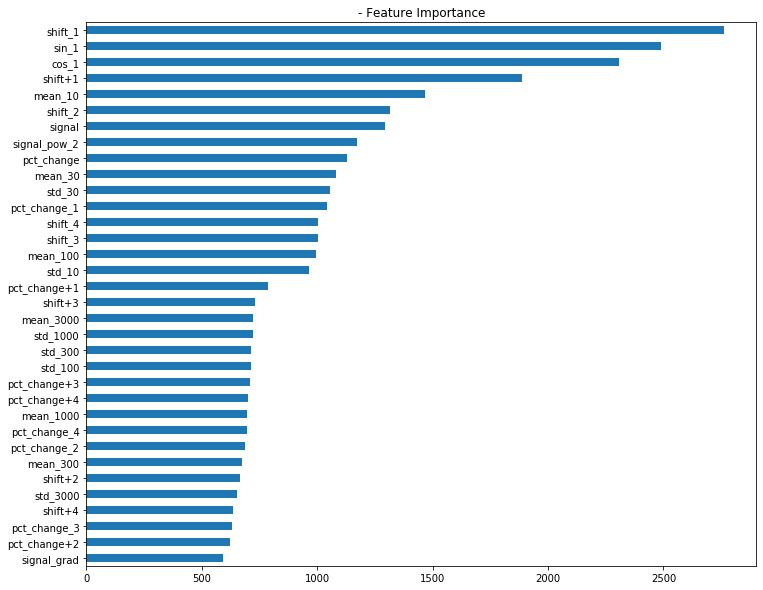

In [13]:
fi_df['importance'] = fi_df.sum(axis=1)
fi_df.sort_values('importance')['importance'][-100:].plot(
    kind='barh',
    figsize=(12, 10),
    title='- Feature Importance',
)
plt.show()


In [14]:
# fig = plt.figure(figsize=(12,5))
# slc = 232 * 1000
# tmp = df_train[slc:slc + 50]
# print(tmp.open_channels.unique())
# tmp.head()

# for i in tmp.open_channels.unique():
#     plt.plot(tmp[tmp.open_channels == i].local_time,
#              tmp[tmp.open_channels == i].signal,
#              ".",
#              markersize=12,
#              c=color_list[i])
#     plt.plot(tmp[tmp.oof == i].local_time,
#              tmp[tmp.oof == i].signal,
#              "s",
#              markersize=12,
#              c=color_list[i])
# plt.grid()

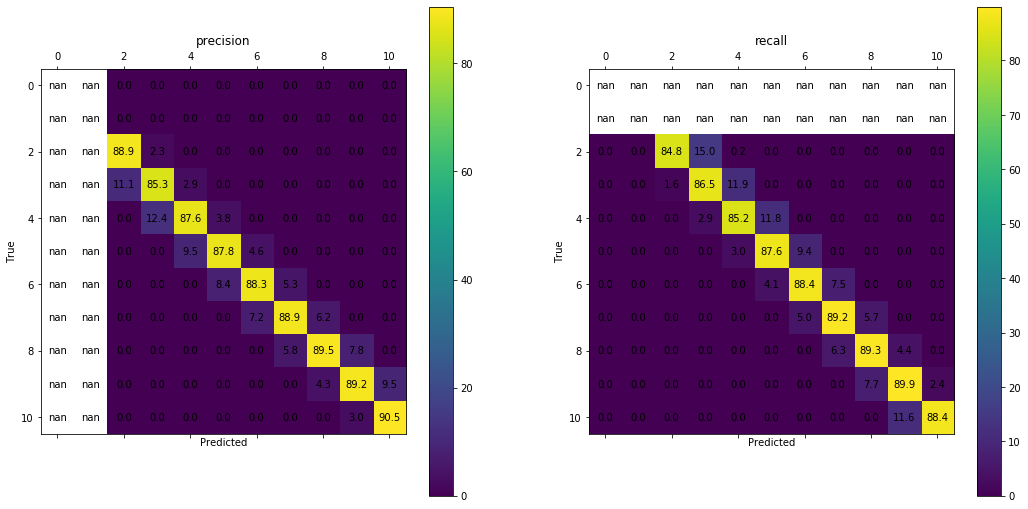

F1 score [  nan   nan 86.81 85.91 86.39 87.68 88.32 89.06 89.37 89.56 89.45]


In [15]:
class_num = 11
cm = confusion_matrix(df_train[TARGET], df_train["oof"], range(11))

# --------------------precision-------------------------
cm_precision = cm / cm.sum(axis=0).reshape([1,-1]) * 100
labels = range(class_num)
fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(121)
cax = ax.matshow(cm_precision)

for (i, j), z in np.ndenumerate(cm_precision):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("precision")

# ------------------------recall---------------------
cm_recall = cm / cm.sum(axis=1).reshape([-1,1]) * 100
labels = range(class_num)
ax = fig.add_subplot(122)
cax = ax.matshow(cm_recall)

for (i, j), z in np.ndenumerate(cm_recall):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("recall")

plt.show()

cm_recall = cm / cm.sum(axis=1).reshape([-1,1])  * np.eye(cm.shape[0])
cm_precision = cm / cm.sum(axis=0).reshape([-1,1]) * np.eye(cm.shape[0])
cm = 2 *(cm_precision * cm_recall) / (cm_precision + cm_recall) * 100

print("F1 score", np.diag(cm).round(2))

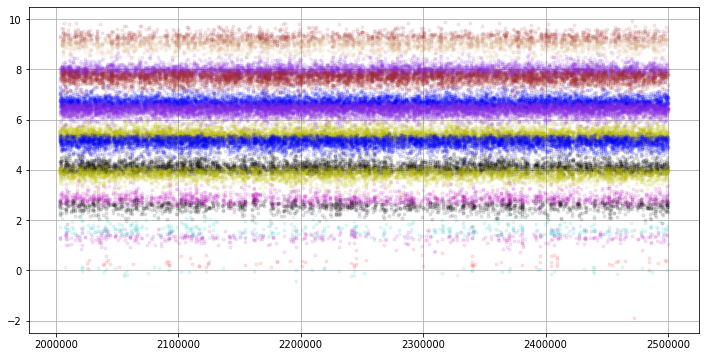

In [16]:
# oof error plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_train[(df_train.open_channels == channel_i)
                      & (df_train.oof != df_train.open_channels)].signal,
             ".",
             color=color_list[channel_i],
             alpha=0.1)

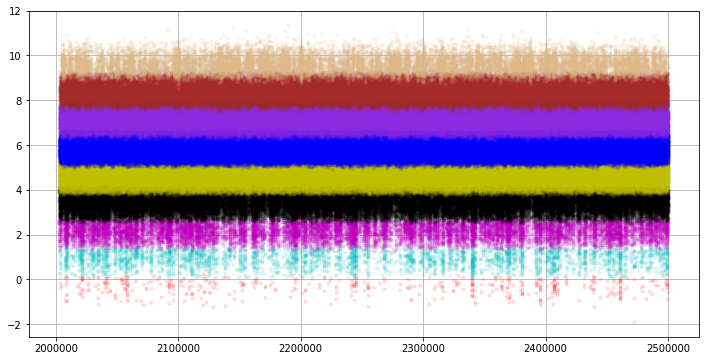

In [17]:
# oof plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_train[df_train.oof == channel_i].signal,
             ".",
             color=color_list[channel_i],
             alpha=0.1)

---

In [18]:
# df_train_sam = df_train.sample(100)

# import eli5
# from eli5.sklearn import PermutationImportance

# # permutation importance step 1: get trained model
# model_lgb = lgb.LGBMRegressor(**param)
# model_lgb.fit(
#     df_train_sam[all_features],
#     df_train_sam[TARGET]
# )

# # run permutation importance
# perm = PermutationImportance(model_lgb,
#                              random_state=42).fit(df_train[all_features],
#                                                   df_train[TARGET],
#                                                   cv=3)

# # show feature importance weight
# eli5.show_weights(perm, feature_names = all_features, top=None)

In [19]:
# # get important features
# feature_importance = pd.DataFrame()
# feature_importance["feature_name"] = all_features
# feature_importance["feature_importance_val"] = perm.feature_importances_

# good_features = feature_importance[
#     feature_importance.feature_importance_val > 0.001].feature_name.tolist()
# print(len(good_features), "features are chosen!")
# print(good_features)

In [20]:
# from sklearn.feature_selection import RFECV

# rfe = RFECV(estimator=model_lgb,
#             step=1,
#             cv=StratifiedKFold(n_splits=5, shuffle=True,
#                                random_state=42).split(
#                                    df_train[all_features],
#                                    y=df_train[TARGET]),
# #             scoring='rmse',
#             verbose=2)

# rfe.fit(df_train[all_features], df_train[TARGET])

In [21]:
# plt.figure(figsize=(14, 8))
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score")
# plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
# plt.show()

In [22]:
# select_all_features = df_train[all_features].columns[rfe.ranking_ == 1]
# print(select_all_features)